![](http://www.dataivy.cn/book/images/head.png)
<table align="center" bgcolor="#FFFFFF" border="0px">
   <tr bgcolor="#FFFFFF">
      <td><img src="http://www.dataivy.cn/book/images/release_date.svg"></td>
      <td><img src="http://www.dataivy.cn/book/images/python-3.7-green.svg"></td>
      <td><a href="http://www.dataivy.cn/blog/python_book_faq/"><img src="http://www.dataivy.cn/book/images/faq-visit_site-blue.svg"></a></td>
      <td><a href="http://www.dataivy.cn/blog/python_book_knows_issues/"><img src="http://www.dataivy.cn/book/images/known_issues.svg"></a></td>
   </tr>
</table>


<hr />

<div align="center"><h1> 第七章&nbsp;&nbsp;流量数据化运营</h1></div>

# 一、案例-基于自动节点树的数据异常原因下探分析

## 说明

- 时间：2019-01-01
- 作者：宋天龙（Tony Song）
- 程序开发环境：win7 64位
- Python版本：64位 3.7
- 依赖库：datetime、numpy、pandas、graphviz
- 程序输入：advertising_data.csv
- 程序输出：打印输出并保存节点树图change_analysis_tree.png

## 程序

### 导入库

In [1]:
import datetime
import numpy as np
import pandas as pd
from graphviz import Digraph  # 画图用库

### 读取数据

In [2]:
raw_data = pd.read_csv('advertising_data.csv')

### 数据审查

In [3]:
# 数据概览
print('{:*^60}'.format('Data overview:'),'\n',raw_data.tail(2))#打印原始数据后2条
print('{:*^60}'.format('Data dtypes:'),'\n',raw_data.dtypes)# 数据类型

***********************Data overview:*********************** 
             date   source    site channel     media visit
10691  2018/6/14  手机_精准营销   UC浏览器      活动    网址导航热词     -
10692  2018/6/14     精准营销  360浏览器      活动  新安装页面欢迎页     -
************************Data dtypes:************************ 
 date       object
source     object
site       object
channel    object
media      object
visit      object
dtype: object


In [4]:
# 缺失值审查
na_cols = raw_data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print('{:*^60}'.format('NA Cols:'))
print(na_cols[na_cols]==True)  # 查看具有缺失值的列
print('Total NA lines is: {0}'.format(raw_data.isnull().any(axis=1).sum()))  # 查看具有缺失值的行总记录数

**************************NA Cols:**************************
Series([], dtype: bool)
Total NA lines is: 0


### 数据预处理

In [5]:
# 替换字符为0然后转换为整数型
raw_data['visit'] = raw_data['visit'].replace('-', 0).astype(np.int64)
print('{:*^60}'.format('Data overview:'))
print(raw_data.tail(2))

***********************Data overview:***********************
            date   source    site channel     media  visit
10691  2018/6/14  手机_精准营销   UC浏览器      活动    网址导航热词      0
10692  2018/6/14     精准营销  360浏览器      活动  新安装页面欢迎页      0


In [6]:
# 将字符串转换为日期格式
raw_data['date'] = pd.to_datetime(raw_data['date'], format='%Y/%m/%d')
print('{:*^60}'.format('Data dtypes:'))
print(raw_data.dtypes)

************************Data dtypes:************************
date       datetime64[ns]
source             object
site               object
channel            object
media              object
visit               int64
dtype: object


### 计算整体波动量

In [7]:
day_summary = raw_data.iloc[:, -1].groupby(raw_data.iloc[:, 0]).sum()  # 按天求和汇总
day_change_value = day_summary.diff(1).rename('change')  # 通过差分求平移1天后的变化量
day_change_rate = (day_change_value.shift(-1) / day_summary).round(3).rename('change_rate').shift(1)  # 求相对昨天的环比变化率
day_summary_total = pd.concat((day_summary, day_change_value, day_change_rate), axis=1)  # 整合为完整数据框
print('{:*^60}'.format('Data change summary:'))
print(day_summary_total.head())

********************Data change summary:********************
             visit   change  change_rate
date                                    
2018-05-15  117260      NaN          NaN
2018-05-16  166124  48864.0        0.417
2018-05-17  157727  -8397.0       -0.051
2018-05-18  155805  -1922.0       -0.012
2018-05-19  115644 -40161.0       -0.258


### 指定日期自动下探分解

In [8]:
# 定义变量
# 分解对象
dimension_list = ['source', 'site', 'channel', 'media']  # 指定要分析的维度：4个层级
# 日期对象
the_day = pd.datetime(2018, 6, 7)  # 指定要分析的日期
previous_day = the_day - datetime.timedelta(1)  # 自动获取前1天日期
# 日期列名
day_col1 = datetime.datetime.strftime(the_day,'%Y-%m-%d')
day_col2 = datetime.datetime.strftime(previous_day,'%Y-%m-%d')
# 数据对象
the_data = raw_data[raw_data['date'] == the_day].rename(columns={'visit': day_col1})  # 获得指定日期数据
previous_data = raw_data[raw_data['date'] == previous_day].rename(columns={'visit': day_col2})  # 获得前1天日期数据

In [9]:
# 数据合并计算
# 合并两天的数据
data_merge = the_data.iloc[:,1:].merge(previous_data.iloc[:,1:],on=dimension_list,how='outer')
# 替换没有匹配的数据为0
data_merge = data_merge.fillna(0)
# 计算相对昨天的环比变化率
data_merge['change'] = data_merge[day_col1]-data_merge[day_col2] # 变化量
data_merge.head()
# 整体对象
visit,change,change_rate = day_summary_total[day_summary_total.index == the_day].values[0]
top_nodes = {'source':'all site','change':change,'change_rate':change_rate}

In [10]:
# 自动节点分解
main_nodes = [] # 主节点
other_nodes = [] # 其他节点
hidden_nodes = [] # 潜在节点
main_edges = [] # 主边
other_edges = [] # 其他边
dim_copy = ['source', 'site', 'channel', 'media', day_col2,'change']
for ind,dimension in enumerate(dimension_list):  # 遍历每个维度
    each_data = data_merge[dim_copy[ind:]] # 筛选数据
    each_merge = each_data.groupby([dimension],as_index=False)[day_col2,'change'].sum() # 计算变化量
    each_merge = each_merge.sort_values(['change']) # 排序
    each_merge['each_change_rate'] = each_merge['change']/each_merge[day_col2] # 环比变化率
    each_merge = each_merge.drop(day_col2,axis=1) # 丢弃当日visit数值列
    change_all = each_merge.sum().iloc[1] # 总变化量
    if change_all<0: # 下降
        # node
        main_values = each_merge.iloc[0].tolist() # 主因子节点
        main_nodes.append(main_values)
        other_nodes.append([f'{dimension}-others',change_all-main_values[1],1-main_values[2]])
        hidden_nodes.append(each_merge.iloc[-1].tolist())
        # 数据过滤
        data_merge = each_data[each_data[dimension]==each_merge.iloc[0].iloc[0]]
    else: # 上升
        # node
        main_values = each_merge.iloc[-1].tolist() # 其他因子节点
        main_nodes.append(main_values)
        other_nodes.append([f'{dimension}-others',change_all-main_values[1],1-main_values[2]])
        hidden_nodes.append(each_merge.iloc[0].tolist())
        # 数据过滤
        data_merge = each_data[each_data[dimension]==each_merge.iloc[-1].iloc[0]]  
    # edge
    edge_values = main_values[1]/float(change_all)
    main_edges.append(edge_values)
    other_edges.append(1-edge_values)

### 画图展示自动下探结果

In [11]:
# 定义各个节点的样式
node_style = '<<table border="0"><tr><td width="20"><table border="1" cellspacing="0" VALIGN="MIDDLE"><tr><td bgcolor="{0}"><font color="{1}"><B>{2}</B></font></td></tr><tr><td>环比变化量:{3:d}</td></tr><tr><td>环比变化率:{4:.2%}</td></tr></table></td></tr></table>>'
edge_style = '<<table border="0"><tr><td><table border="0" cellspacing="0" VALIGN="MIDDLE" bgcolor="#ffffff"><tr><td>{0}</td></tr><tr><td>贡献率:{1:.0%}</td></tr></table></td></tr></table>>'
attr_node = {'fontname': "SimHei", 'shape': 'box','penwidth' : '0'}  # 定义node节点样式
attr_edge = {'fontname': "SimHei"}  # 定义edge节点样式
attr_graph = {'fontname': "SimHei", 'splines': 'ortho','nodesep' : '2'}  # Graph的总体样式

In [12]:
# 定义左侧父级图
parent_dot = Digraph(format='png', graph_attr=attr_graph, node_attr={'shape': 'plaintext', 'fontname': 'SimHei'}) 
features = ['全站','source', 'site', 'channel', 'media']
parent_edge = [(features[i],features[i+1]) for i in range(len(features)-1)]
parent_dot.edges(parent_edge)

In [13]:
# 定义右侧子级图
child_dot = Digraph(node_attr=attr_node, edge_attr=attr_edge)  # 创建有向图
for tree_depth in range(len(main_nodes)):  # 循环读取每一层
    split_node_left = main_nodes[tree_depth]
    split_node_right = other_nodes[tree_depth]
    split_node_hidden = hidden_nodes[tree_depth]

    if tree_depth == 0:
        # 增加顶部节点
        node_name = '汇总值'
        node_top_label = node_style.format( 'black',"white",node_name,
                                               int(top_nodes['change']),
                                               top_nodes['change_rate'])  # 分别获取顶部节点名称、变化量和变化率
        child_dot.node('汇总值', label=node_top_label)  # 增加顶部节点
    else:
        node_name = main_nodes[tree_depth - 1][0]  # 将上级左侧分裂节点作为下级节点的source

    # 增加node信息
    node_label_left = node_style.format("#184da5","white",split_node_left[0],
                                             int(split_node_left[1]),
                                             split_node_left[2])  # 左侧节点显示的信息
    node_label_right = node_style.format("#d3d3d3","black",split_node_right[0],
                                               int(split_node_right[1]),
                                               split_node_right[2])  # 右侧节点显示的信息
    node_label_hidden = node_style.format("#72a518","black",split_node_hidden[0],
                                               int(split_node_hidden[1]),
                                               split_node_hidden[2])  # 潜在节点显示的信息
    # 增加边信息
    edge_label_left = edge_style.format('主因子',main_edges[tree_depth])  # 左侧边的标签信息
    edge_label_right = edge_style.format('其他因子',other_edges[tree_depth])  # 右侧边的标签信息

    # 节点和边画图
    child_dot.node(split_node_left[0], label=node_label_left)  # 增加左侧节点
    child_dot.node(split_node_right[0], label=node_label_right)  # 增加右侧节点
    child_dot.node(split_node_hidden[0], label=node_label_hidden)  # 增加隐藏节点
    child_dot.edge(node_name, split_node_left[0], label=edge_label_left)  # 增加左侧边
    child_dot.edge(node_name, split_node_right[0], label=edge_label_right)  # 增加右侧边
    child_dot.edge(split_node_right[0], split_node_hidden[0],label = '潜在因子')  # 增加隐藏节点边

parent_dot.subgraph(child_dot)
parent_dot.view('change_analysis_tree')  # 展示图形结果

'change_analysis_tree.png'

# 二、案例-基于自动K值的KMeans广告效果聚类分析

## 说明

- 时间：2019-01-01
- 作者：宋天龙（Tony Song）
- 程序开发环境：win7 64位
- Python版本：64位 3.7
- 依赖库：matplotlib、numpy、pandas、sklearn
- 程序输入：ad_performance.txt
- 程序输出：打印输出不同聚类类别的信息

## 程序

### 导入库

In [14]:
import matplotlib.pyplot as plt  # 图形库
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score  # 导入轮廓系数指标
from sklearn.cluster import KMeans  # KMeans模块
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder  # 数据预处理库

### 读取数据

In [15]:
raw_data = pd.read_table('ad_performance.txt', delimiter='\t')

### 数据审查

In [16]:
# 查看基本状态
print('{:*^60}'.format('Data overview:'))
print(raw_data.head(2))  # 打印输出前2条数据
print('{:*^60}'.format('Data dtypes:'))
print(pd.DataFrame(raw_data.dtypes).T)  # 打印数据类型分布
print('{:*^60}'.format('Data DESC:'))
print(raw_data.describe().round(2).T)  # 打印原始数据基本描述性信息

***********************Data overview:***********************
   渠道代号    日均UV   平均注册率   平均搜索量    访问深度  平均停留时间   订单转化率  投放总时间 素材类型    广告类型  \
0  A203    3.69  0.0071  0.0214  2.3071  419.77  0.0258     20  jpg  banner   
1  A387  178.70  0.0040  0.0324  2.0489  157.94  0.0030     19  jpg  banner   

  合作方式    广告尺寸 广告卖点  
0  roi  140*40   打折  
1  cpc  140*40   满减  
************************Data dtypes:************************
     渠道代号     日均UV    平均注册率    平均搜索量     访问深度   平均停留时间    订单转化率  投放总时间  \
0  object  float64  float64  float64  float64  float64  float64  int64   

     素材类型    广告类型    合作方式    广告尺寸    广告卖点  
0  object  object  object  object  object  
*************************Data DESC:*************************
        count    mean      std   min     25%     50%     75%       max
日均UV    889.0  540.85  1634.41  0.06    6.18  114.18  466.87  25294.77
平均注册率   889.0    0.00     0.00  0.00    0.00    0.00    0.00      0.04
平均搜索量   889.0    0.03     0.11  0.00    0.00    0.00    0.01   

In [17]:
# 缺失值审查
na_cols = raw_data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print('{:*^60}'.format('NA Cols:'))
print(na_cols[na_cols==True])  # 查看具有缺失值的列
print('Total number of NA lines is: {0}'.format(
    raw_data.isnull().any(axis=1).sum()))  # 查看具有缺失值的行总记录数

**************************NA Cols:**************************
平均停留时间    True
dtype: bool
Total number of NA lines is: 2


In [18]:
# 相关性分析
print('{:*^60}'.format('Correlation analysis:'))
print(raw_data.corr().round(2).T)  # 打印原始数据相关性信息

*******************Correlation analysis:********************
        日均UV  平均注册率  平均搜索量  访问深度  平均停留时间  订单转化率  投放总时间
日均UV    1.00  -0.05  -0.07 -0.02    0.04  -0.05  -0.04
平均注册率  -0.05   1.00   0.24  0.11    0.22   0.32  -0.01
平均搜索量  -0.07   0.24   1.00  0.06    0.17   0.13  -0.03
访问深度   -0.02   0.11   0.06  1.00    0.72   0.16   0.06
平均停留时间  0.04   0.22   0.17  0.72    1.00   0.25   0.05
订单转化率  -0.05   0.32   0.13  0.16    0.25   1.00  -0.00
投放总时间  -0.04  -0.01  -0.03  0.06    0.05  -0.00   1.00


### 数据预处理

In [19]:
# 删除平均平均停留时间列
raw_data2 = raw_data.drop(['平均停留时间'], axis=1)

In [20]:
# 字符串分类onehotencode处理
cols = ['素材类型','广告类型','合作方式','广告尺寸','广告卖点']
model_ohe = OneHotEncoder(sparse=False)  # 建立OneHotEncode对象
ohe_matrix = model_ohe.fit_transform(raw_data2[cols])  # 直接转换
print(ohe_matrix[:2])

[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0.]]


In [21]:
# 数据标准化
sacle_matrix = raw_data2.iloc[:, 1:7]  # 获得要转换的矩阵
model_scaler = MinMaxScaler()  # 建立MinMaxScaler模型对象
data_scaled = model_scaler.fit_transform(sacle_matrix)  # MinMaxScaler标准化处理
print(data_scaled.round(2))

[[0.   0.18 0.02 0.01 0.12 0.66]
 [0.01 0.1  0.03 0.01 0.01 0.62]
 [0.   0.06 0.05 0.01 0.01 0.1 ]
 ...
 [0.01 0.01 0.   0.   0.   0.72]
 [0.05 0.   0.   0.   0.   0.31]
 [0.   0.   0.   0.53 0.   0.62]]


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [22]:
# 合并所有维度
X = np.hstack((data_scaled, ohe_matrix))

### KMeans建模

In [23]:
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(X)  # 训练聚类模型
    silhouette_tmp = silhouette_score(X, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K value and silhouette summary:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('Best K is:{0} with average silhouette of {1}'.format(best_k, silhouette_int))

**************K value and silhouette summary:***************
[[2.         0.38655493]
 [3.         0.45757883]
 [4.         0.50209812]]
Best K is:4 with average silhouette of 0.5020981194788054


### 聚类结果分析

In [24]:
# part1 将原始数据与聚类标签整合
cluster_labels = pd.DataFrame(cluster_labels_k, columns=['clusters'])  # 获得训练集下的标签信息
merge_data = pd.concat((raw_data2, cluster_labels), axis=1)  # 将原始处理过的数据跟聚类标签整合

# part2 计算每个聚类类别下的样本量和样本占比
clustering_count = pd.DataFrame(merge_data['渠道代号'].groupby(merge_data['clusters']).count()).T.rename({'渠道代号': 'counts'})  # 计算每个聚类类别的样本量
clustering_ratio = (clustering_count / len(merge_data)).round(2).rename({'counts': 'percentage'})  # 计算每个聚类类别的样本量占比

# part3 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(best_k):  # 读取每个类索引
    label_data = merge_data[merge_data['clusters'] == line]  # 获得特定类的数据

    part1_data = label_data.iloc[:, 1:7]  # 获得数值型数据特征
    part1_desc = part1_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part1_desc.iloc[2, :]  # 得到数值型特征的均值

    part2_data = label_data.iloc[:, 7:-1]  # 获得字符串型数据特征
    part2_desc = part2_data.describe(include='all')  # 获得字符串型数据特征的描述性统计信息
    merge_data2 = part2_desc.iloc[2, :]  # 获得字符串型数据特征的最频繁值

    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # 将数值型和字符串型典型特征沿行合并
    cluster_features.append(merge_line)  # 将每个类别下的数据特征追加到列表
# part4 输出完整的类别特征信息
cluster_pd = pd.DataFrame(cluster_features).T  # 将列表转化为矩阵
print('{:*^60}'.format('Detailed features for all clusters:'))
all_cluster_set = pd.concat((clustering_count, clustering_ratio, cluster_pd),axis=0)  # 将每个聚类类别的所有信息合并
print(all_cluster_set)

************Detailed features for all clusters:*************
clusters          0        1        2        3
counts          349      313      154       73
percentage     0.39     0.35     0.17     0.08
日均UV        933.015  1390.01  2717.42  1904.37
平均注册率         0.003    0.003    0.005    0.003
平均搜索量         0.064    0.152    0.051    0.106
访问深度          5.916    1.168    0.947    0.943
订单转化率         0.006    0.017    0.007    0.009
投放总时间          8.77    8.199    8.529    8.217
素材类型            jpg      swf      jpg      swf
广告类型             横幅      不确定   banner     tips
合作方式            cpc      roi      cpc      cpm
广告尺寸         600*90   600*90  308*388  450*300
广告卖点             直降       打折       满减       打折


### 各类别显著数值特征对比

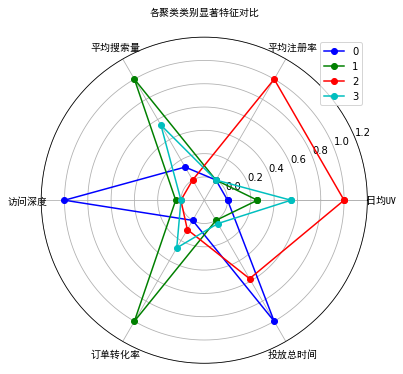

In [25]:
# part1 各类别数据预处理
num_sets = cluster_pd.iloc[:6, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
# part2 画布基本设置
fig = plt.figure(figsize=(6,6))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
# part3 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
    ax.plot(angles, data, 'o-', c=cor_list[i], label=i)  # 画线
# part4 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")  # 设置极坐标轴
ax.set_title("各聚类类别显著特征对比", fontproperties="SimHei")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc=0)  # 设置图例位置